In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Load the dataset
df = pd.read_csv('ranked_data.csv')  # Replace with your actual file name


In [21]:
# Prepare the features and target
X = df.drop(['Unnamed: 0', 'striker', 'Overall_score','Rank'], axis=1)
y = df['Overall_score']

In [22]:
# Encode categorical variables
le = LabelEncoder()
X['Player_type'] = le.fit_transform(X['Player_type'])

In [23]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [25]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [26]:

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Perform RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                               n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\niran\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
245 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
132 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\niran\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\niran\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\niran\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [27]:
# Get the best model
best_rf_model = rf_random.best_estimator_

# Perform feature selection
selector = SelectFromModel(best_rf_model, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

c:\Users\niran\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\niran\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [28]:
# Train the final model on selected features
final_model = RandomForestRegressor(**rf_random.best_params_, random_state=42)
final_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = final_model.predict(X_test_selected)

In [29]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Accuracy: {r2 * 100:.2f}%")

Mean Squared Error: 5.564417967827715
R-squared Score: 0.9879148111371704
Accuracy: 98.79%


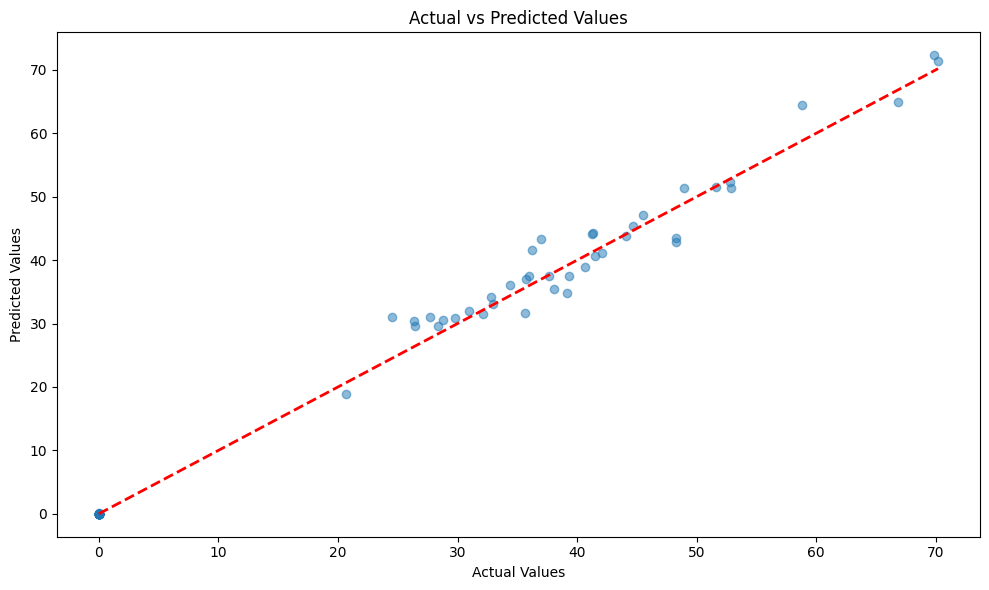

In [30]:
# 1. Actual vs Predicted values scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

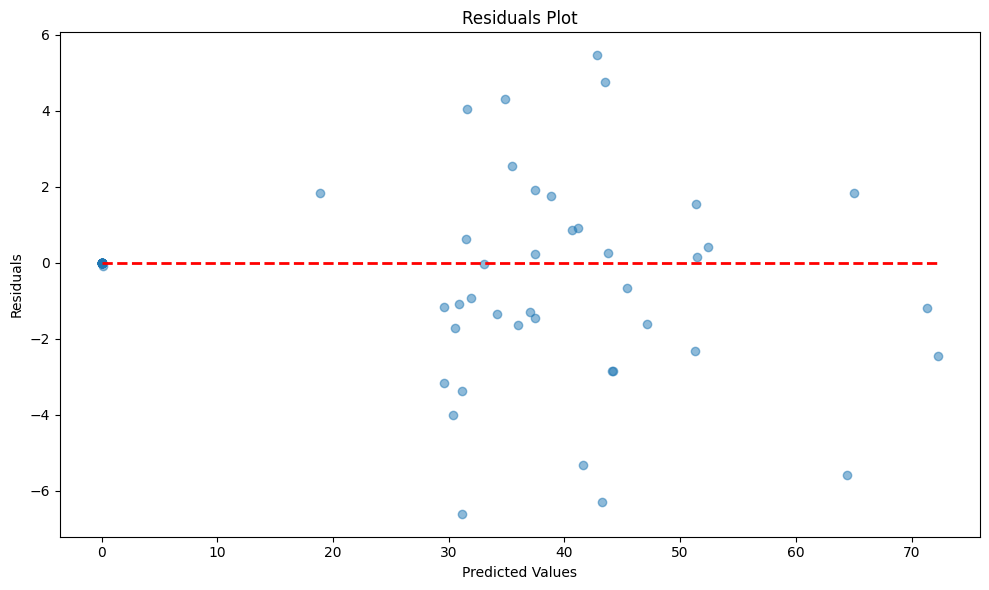

In [31]:
# 2. Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'r--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.tight_layout()
plt.show()

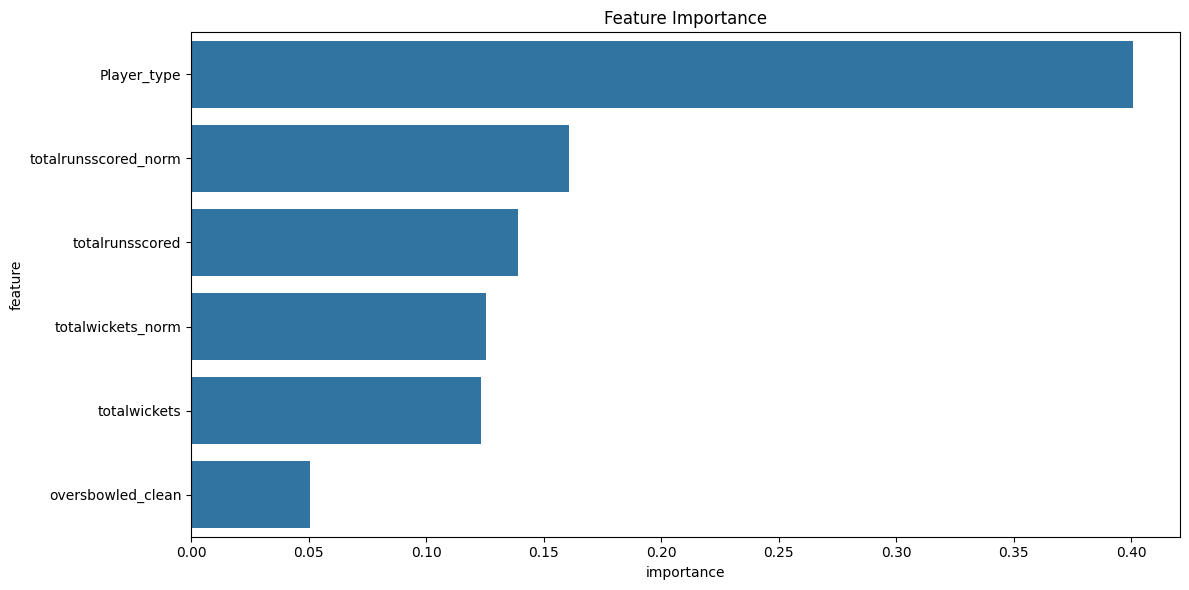

In [32]:
# 3. Feature importance bar chart
selected_features = X.columns[selector.get_support()]
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

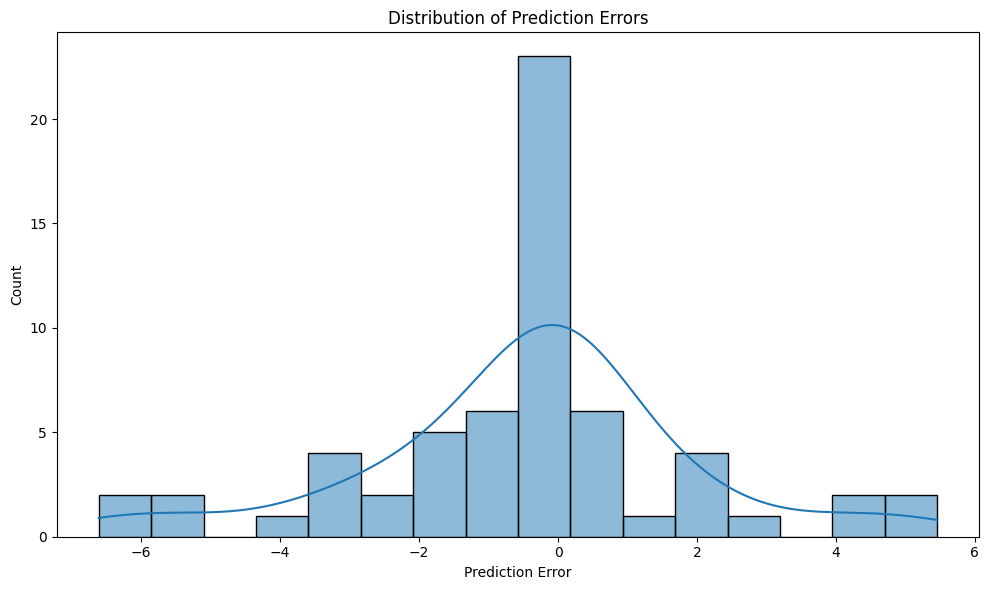

In [33]:
# 4. Prediction error distribution histogram
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.tight_layout()
plt.show()

This enhanced model includes the following improvements:
Feature Scaling: StandardScaler is used to normalize the features, which can help improve model performance.

Hyperparameter Tuning: RandomizedSearchCV is used to search for the best hyperparameters for the Random Forest model.
Feature Selection: SelectFromModel is used to select the most important features, which can help reduce overfitting and improve model generalization.

Final Model Training: The model is retrained on the selected features using the best hyperparameters found.
The code also includes the same visualizations as before to help you interpret the results.

This approach should potentially yield better accuracy while reducing the risk of overfitting. The model's performance metrics (MSE, R-squared, and Accuracy) are printed, allowing you to compare with your previous model.

Remember that the RandomizedSearchCV process can take some time to run, especially with a large dataset. You may want to adjust the n_iter parameter in RandomizedSearchCV if you need faster results.

n_estimators: [100, 200, 300, 400, 500]
This parameter sets the number of trees in the forest.
More trees can lead to better performance but increase computation time.
The search will try forests with 100, 200, 300, 400, and 500 trees.
max_depth: [10, 20, 30, 40, 50, None]
This sets the maximum depth of each tree.
Deeper trees can model more complex relationships but may lead to overfitting.
'None' means nodes are expanded until all leaves are pure or contain less than min_samples_split samples.
min_samples_split: [2, 5, 10]
The minimum number of samples required to split an internal node.
Higher values prevent creating too many nodes with few samples, which can help prevent overfitting.
min_samples_leaf: [1, 2, 4]
The minimum number of samples required to be at a leaf node.
Similar to min_samples_split, this helps control the complexity of the trees.
max_features: ['auto', 'sqrt']
The number of features to consider when looking for the best split.
'auto' is equivalent to 'sqrt' for Random Forest.
'sqrt' means the model will consider the square root of the total number of features.
This hyperparameter space defines a grid of possible combinations. The RandomizedSearchCV will randomly sample from this space to find the best combination of hyperparameters.
For example, one combination might be:
n_estimators: 300
max_depth: 20
min_samples_split: 5
min_samples_leaf: 2
max_features: 'sqrt'
The search process will try many such combinations (as specified by n_iter in RandomizedSearchCV) and use cross-validation to evaluate each one, ultimately selecting the best-performing set of hyperparameters.

In [34]:
# Assuming the model is already trained and named 'final_model'
# and the feature selector is named 'selector'

# Create example data for a new player
new_player_data = pd.DataFrame({
    'totalrunsscored': [500],
    'Total_batting_average': [35.5],
    'batting_strike_rate': [140.2],
    'totalballsfaced': [356],
    'totalwickets': [10],
    'economyrate': [7.8],
    'oversbowled_clean': [40.0],
    'totalrunsscored_norm': [0.22],  # These normalized values are hypothetical
    'Total_batting_average_norm': [0.51],
    'batting_strike_rate_norm': [0.47],
    'totalwickets_norm': [0.12],
    'economyrate_norm': [0.65],
    'Player_type': ['All-rounder']  # Assuming 'All-rounder' is a valid category


})

# Encode the 'Player_type'
new_player_data['Player_type'] = le.transform(new_player_data['Player_type'])

# Scale the features
new_player_scaled = scaler.transform(new_player_data)

# Select features (if feature selection was used)
new_player_selected = selector.transform(new_player_scaled)

# Make prediction
predicted_score = final_model.predict(new_player_selected)

print(f"Predicted Overall Score for the new player: {predicted_score[0]:.2f}")

# You can also print the feature importances for this prediction
feature_importance = pd.DataFrame({
    'feature': X.columns[selector.get_support()],
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Important Features for this prediction:")
print(feature_importance.head())

Predicted Overall Score for the new player: 31.95

Top 5 Important Features for this prediction:
                feature  importance
5           Player_type    0.400635
3  totalrunsscored_norm    0.160711
0       totalrunsscored    0.139175
4     totalwickets_norm    0.125428
1          totalwickets    0.123415
